# P5 : Pipline for Vehicle Detection and Tracking

This is the project report for the 5th and final Project for Term-1. Here, I will be going through each of the project rubric points as seprate sections and include explanation with example images to better represent a state of the code pipeline.


** Prep for the pipeline**

In [1]:
# importing all the libraries that will be required for this project
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time

from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

In [2]:
def plotThreeImagesInRow(image1, image2, image3, title1='image1', title2='image2', title3='image3'):
    plt.clf() # clear any previous saved data
    
    # creating layout to place three image sided-by-side with their respective title
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1, cmap='gray')
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(image2, cmap='gray')
    ax2.set_title(title2, fontsize=50)
    ax3.imshow(image3, cmap='gray')
    ax3.set_title(title3, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
def plotTwoImageInRow(image1, image2, title1='image1', title2='image2'):
    plt.clf()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1, cmap='gray')
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(image2, cmap='gray')
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

Loading images in a list and creating a subset of first 3 images to test parameters and methods that is going to be used later in the notebook

In [3]:
# Reading vehicle and non-vehicle images and gettig a sense of the data
all_cars = glob.glob('training_samples/vehicles/*/*.png')
all_non_cars = glob.glob('training_samples/non-vehicles/*/*.png')
print('Total car images',len(all_cars), ', Total non-car images:', len(all_non_cars))

Total car images 8792 , Total non-car images: 8968


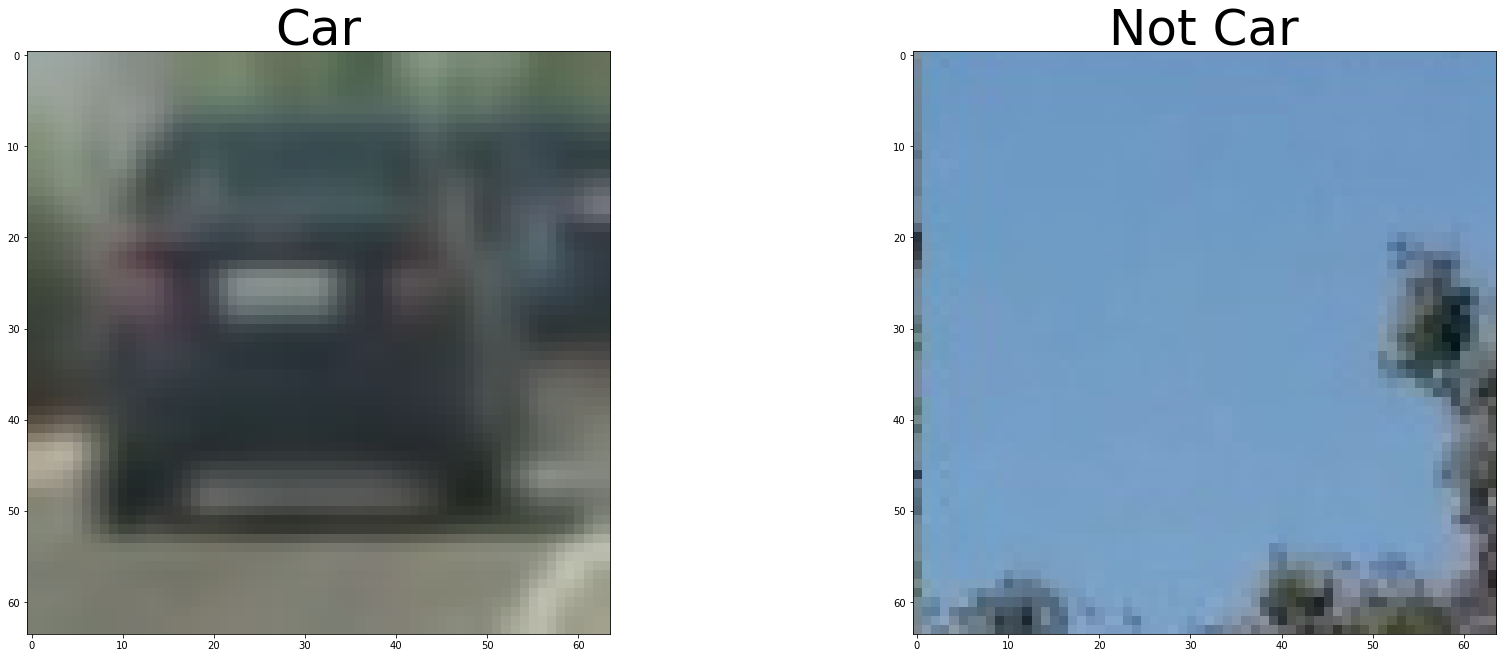

In [4]:
# display one car and one non car image
plotTwoImageInRow(mpimg.imread(all_cars[0]), mpimg.imread(all_non_cars[0]), 'Car', 'Not Car')

## 1. Histogram of Oriented Gradients (HOG)

**1.a : Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.**

Following cells describe the method that extracts the HOG feature using the **hog()** method. The parameters are set after experimenting with few values. I have chosen these values based on how the classifier performs. Few things that helped me qualify the parameter values were accuracy and speed of classification.

I have found that increasing the values too much makes the result worse and slower as it increases the no of features by a significant margin. Through my experimentation I found that classification perform better between the following range:

1. orient = 9-11
2. pix_per_cell = 8-20
3. cell_per_block = 2-4

Out of these I settled with below values:

- orient = 11
- pix_per_cell = 16
- cell_per_block = 2

I kept **hog_channle** value to **'ALL'** thoughtout the project as I am only using one feature for classification. Hence wanted to increase the dataset.


In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

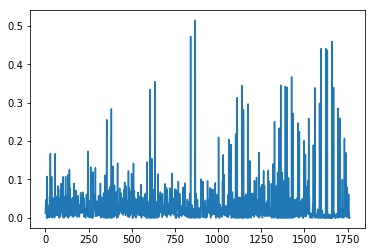

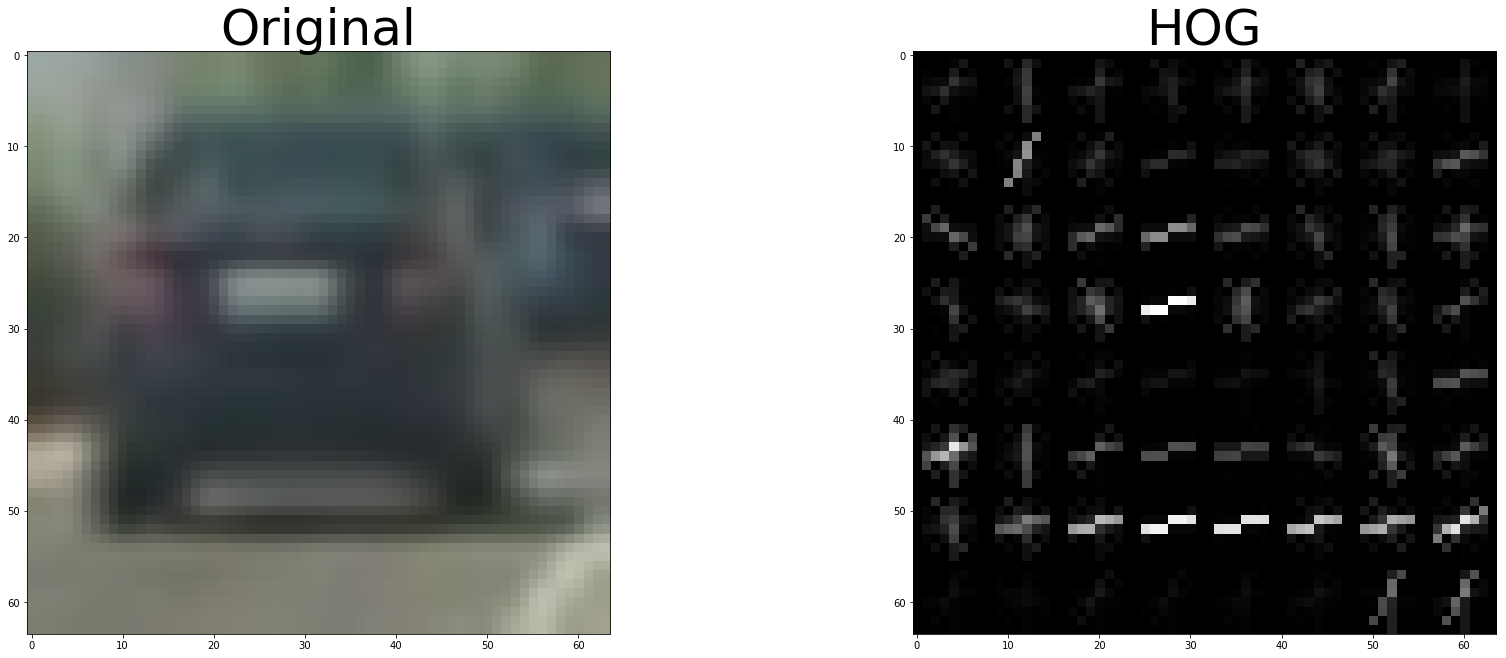

In [6]:
# Visualizing HOG feature extraction
test_img = mpimg.imread(all_cars[0])
orient = 9
pix_per_cell = 8
cell_per_block = 2
features, hog_img = get_hog_features(test_img[:,:,2],orient, pix_per_cell, cell_per_block, vis=True)

plt.plot(features)
plt.show()
plotTwoImageInRow(test_img, hog_img, 'Original', 'HOG')

**1.b : Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them)**

I started with creating the training set based out of HOG features only. I was thinking of adding other features if HOG wont suffice. But, it never came to that. HOG proved to be enough to classify cars and non cars features in images as well as videos.

I tried with some of color schemes though and finally setteled on **YCrCb**.

I have used the SVM classifier. Following are the steps that goes into building and training the classifier:

1. **Extracting features : **I have used only HOG features for this classification across all channels.
2. **Normalizing the features : **Normalization was not required in this case as the dataset contains only one type of feature.
3. **Train/Test splitting of data : **I then divided the dataset into training the testing set. I have kept the testing test as 20% of the total data.
3. **Create, train and test the classifier : **For classification I have created a **Linear SVM** classifier and train and tested it out with different parameter yielding different accuracies. My final values for them in listed in the following cells

Using these values I was able to get the accuracy of 97.89%.

In [7]:
def extract_features(imgs, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        #print(hog_features.shape)
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [8]:
# parameters for extracting the features
colorspace = 'YCrCb'
orient = 11
pix_per_cell = 16
cell_per_block =2
hog_channel = 'ALL'

In [9]:
# extracting features for cars and not-car images
t=time.time()
car_features = extract_features(all_cars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(all_non_cars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()

# display time complexities for the above action
print(round(t2-t, 2), 'Seconds to extract HOG features...')
print(len(car_features), len(notcar_features))

41.41 Seconds to extract HOG features...
8792 8968


In [10]:
# Stacking all the feature vectors for cars and non-car images.
# And then normalizing them all so that one feature doesnt become dominant in classification
X = np.vstack((car_features, notcar_features)).astype(np.float64)
#X_scalar = StandardScaler().fit(X)
#scaled_X = X_scalar.transform(X)
#print(scaled_X.shape)

# creating the labels vectors for cars and non-cars images
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


print(X.shape, y.shape)

(17760, 1188) (17760,)


In [11]:
# spliting the sample data into training and testing set
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

Feature vector size: 1188


Feature vector sample visulaization


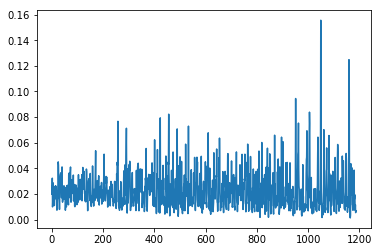

In [12]:
print('Feature vector size:',len(X_train[0]))
print('\n\nFeature vector sample visulaization')
plt.plot(X_train[0])
plt.show()

In [13]:
# Training a Linear SVM Classifier for this project. One of the reason I chose to stay with SVM
# classfier is that it gives more options to fine tune and its very fast on CPU also which is my case.
svc = LinearSVC()
t1 = time.time() # start time
svc.fit(X_train, y_train)
t2 = time.time() # end time

print(round(t2-t, 2), 'Seconds to train SVC...')

# Checking the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Checking the prediction time for a single sample of 10 elements
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[:n_predict]))
print('For these',n_predict, 'labels: ', y_test[:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

43.14 Seconds to train SVC...
Test Accuracy of SVC =  0.9823
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.001 Seconds to predict 10 labels with SVC


## 2. Sliding Window Search ##

**2.a : Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?
**

For the sliding windows search I went with the second aproach described in details in the lesson. I chose this approach as it was much simpler in implementation, understanding and performance. I adjusted the method to only take the HOG features into account.

What this method does is, it calculated the HOG features, only once, in the test image before hand and then use the same to loop through and detect the objects. I dont have get HOG feature each time I loop through a patch. This made things very simpler and effective.

Playing with different area and scaling parameter, I found that to recognise car at different distances from the camera I have to poll the same image with different scaling values. After that I created a heatmap with found rectangles and applied a threshold to exclude false positives. Using the remaining rectangles I created the bounding boxes for cars.


In [14]:
# Function for finding the car in a given image. This method is more poweful than traditional sliding
# windows search algorithm as its only once required to calculate the HOG which can be reused as many times as
# required.
def find_cars(img, ystart, ystop, scale, color_space, svc, orient, pix_per_cell, cell_per_block):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    # Rescaling the image to optimised for classifier trained with PNG images
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else:
        ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Using the classifier to guess the whether the image patch is a car or not
            test_prediction = svc.predict(hog_features.reshape(1,-1))
            
            # If YES, save the rectangle
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [15]:
ystart = 400
ystop = 656
scale = 2
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

test_scene = mpimg.imread('test_images/test1.jpg')

rectangles = find_cars(test_scene, ystart, ystop, scale, colorspace, svc, orient, pix_per_cell, cell_per_block)

print(len(rectangles), ' rectangles which might contain a car.')

6  rectangles which might contain a car.


In [16]:
# function to draw the rectangles found in above cells onto the given image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

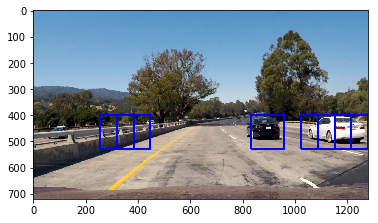

In [17]:
test_img_rects = draw_boxes(test_scene, rectangles)
plt.imshow(test_img_rects)
plt.show()

In [18]:
# function to experiment with different scaling and windows search area easily
def find_cars_withing_area(img, ystart=400, yend=650, scale=1, isVideo=True):
    
    rectangles = find_cars(img, ystart, ystop, scale, colorspace, svc, orient, pix_per_cell, cell_per_block)
    
    if isVideo is False:
        test_img_rects = draw_boxes(img, rectangles)
        plt.imshow(test_img_rects)
        plt.show()
    
    return rectangles

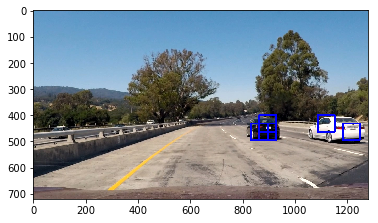

[((832, 432), (896, 496)),
 ((864, 400), (928, 464)),
 ((864, 432), (928, 496)),
 ((1088, 400), (1152, 464)),
 ((1184, 432), (1248, 496))]

In [19]:
find_cars_withing_area(test_scene, ystart=400, yend=450, scale=1, isVideo=False)

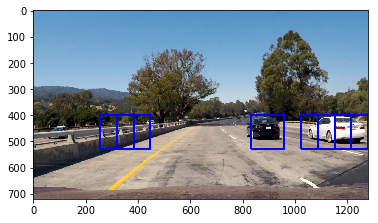

[((256, 400), (384, 528)),
 ((320, 400), (448, 528)),
 ((832, 400), (960, 528)),
 ((1024, 400), (1152, 528)),
 ((1088, 400), (1216, 528)),
 ((1152, 400), (1280, 528))]

In [20]:
find_cars_withing_area(test_scene, ystart=400, yend=450, scale=2, isVideo=False)

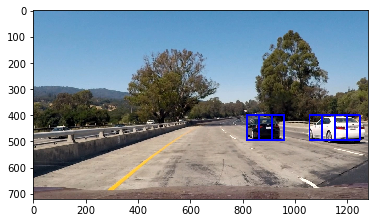

[((816, 400), (912, 496)),
 ((864, 400), (960, 496)),
 ((1056, 400), (1152, 496)),
 ((1104, 400), (1200, 496)),
 ((1152, 400), (1248, 496))]

In [21]:
find_cars_withing_area(test_scene, ystart=400, yend=650, scale=1.5, isVideo=False)

**Creating Heatmaps and merging rectangles based on that.**

In [22]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img

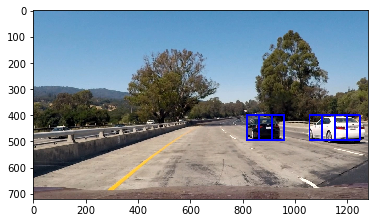

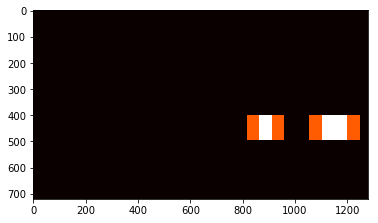

In [23]:
# creating a heatmap with all the rectangles that have been found
rectangles = find_cars_withing_area(test_scene, ystart=400, yend=650, scale=1.5, isVideo=False)
heatmap = np.zeros_like(test_scene[:,:,0])
heatmap = add_heat(heatmap, rectangles)
plt.imshow(heatmap, cmap='hot')
plt.show()

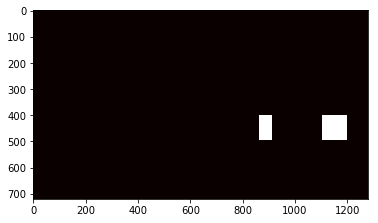

In [24]:
# applying threshold on the heatmap to exclude fake detections
heatmap = apply_threshold(heatmap, 1)
plt.imshow(heatmap, cmap='hot')
plt.show()

Total cars detected 2


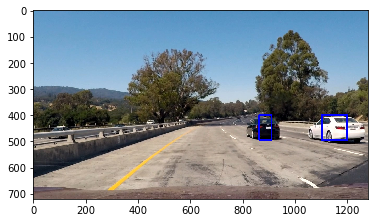

In [25]:
# creating labels for detected cars and drawing a rectangle around them
labels = label(heatmap)
print('Total cars detected', len(labels))
draw_img = draw_labeled_bboxes(np.copy(test_scene), labels)
plt.imshow(draw_img, cmap='hot')
plt.show()

### Testing the pipeline on all test images

In [26]:
# image here should be JPG only as i am scaling the image based on assumption that test images and
# video frames is going to in the same format. Otherwise, we have to include a check for the same.
def process_image(image_frame):
    
    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    
    ystart = 400
    yend = 656
    
    # getting the rectangle
    rectangles_found = []
    rectangles_found.append(find_cars_withing_area(image_frame, ystart=ystart, yend=yend, scale=2, isVideo=True))
    rectangles_found.append(find_cars_withing_area(image_frame, ystart=ystart, yend=yend, scale=1.5, isVideo=True))
    rectangles_found.append(find_cars_withing_area(image_frame, ystart=ystart, yend=yend, scale=1, isVideo=True))
    rectangles_found.append(find_cars_withing_area(image_frame, ystart=ystart, yend=yend, scale=0.8, isVideo=True))
    
    rectangles_found = [item for rec in rectangles_found for item in rec]
    
    # analysing the heatmaps for final rectangles to draw for each car, if any
    heatmap = np.zeros_like(image_frame[:,:,0])
    heatmap = add_heat(heatmap, rectangles_found)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image_frame), labels)
    
    return draw_img

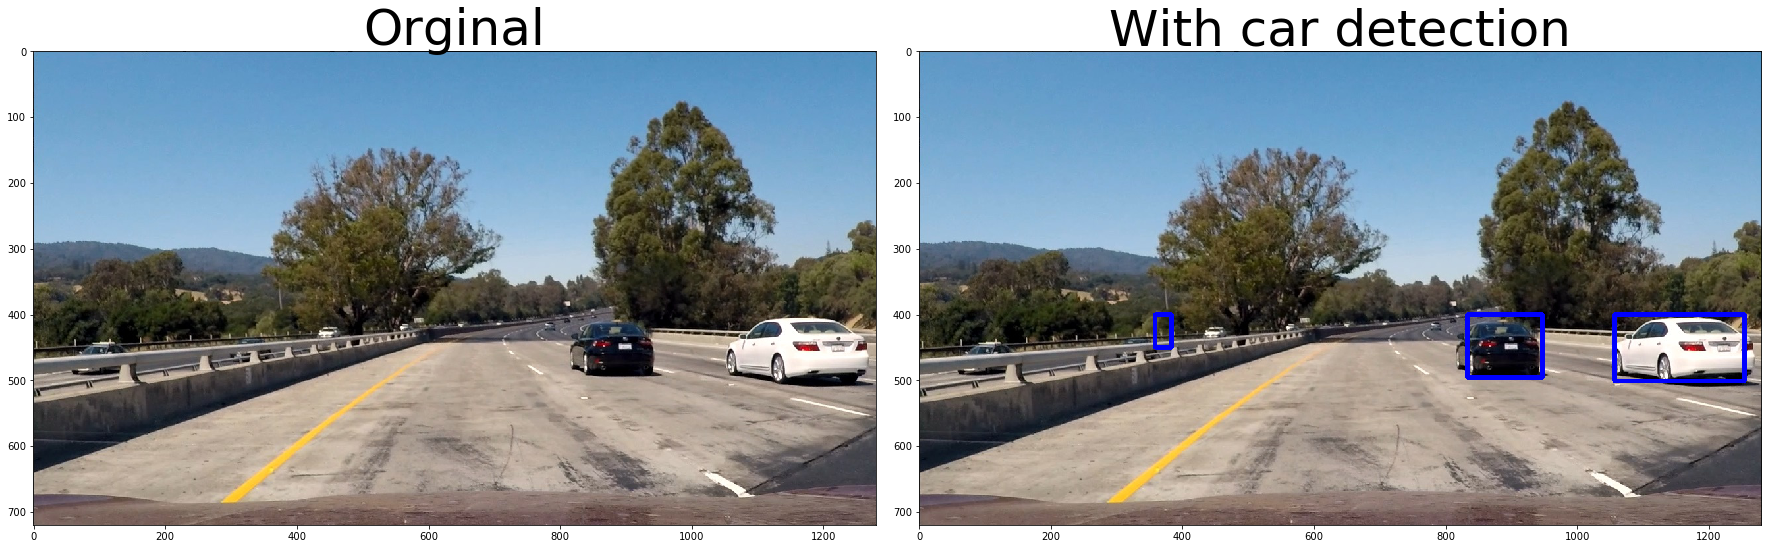

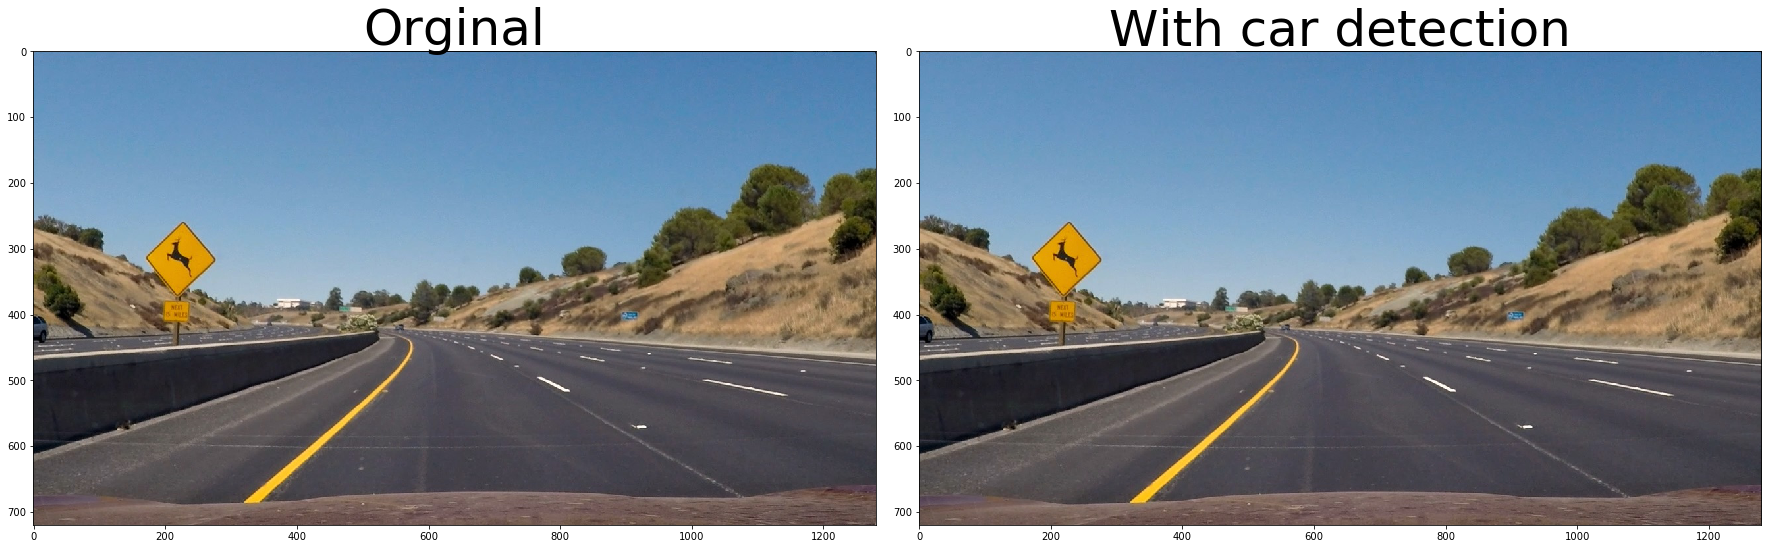

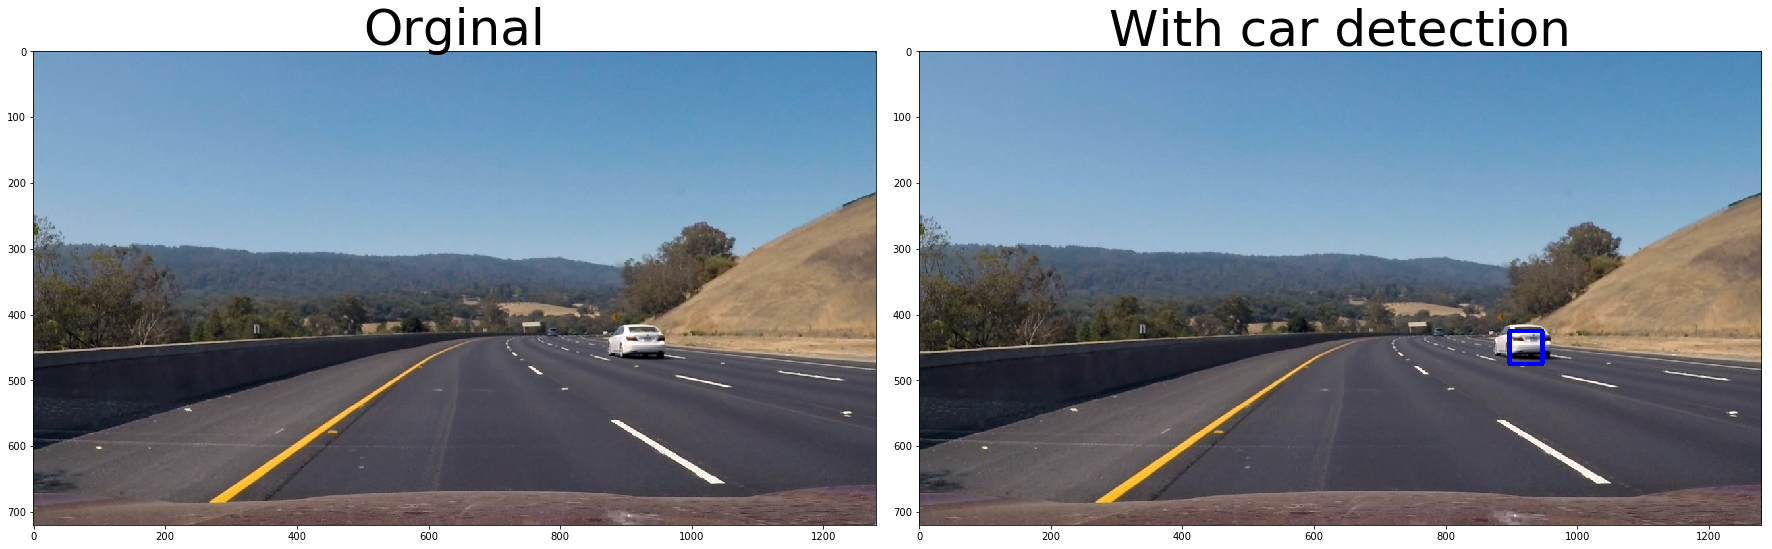

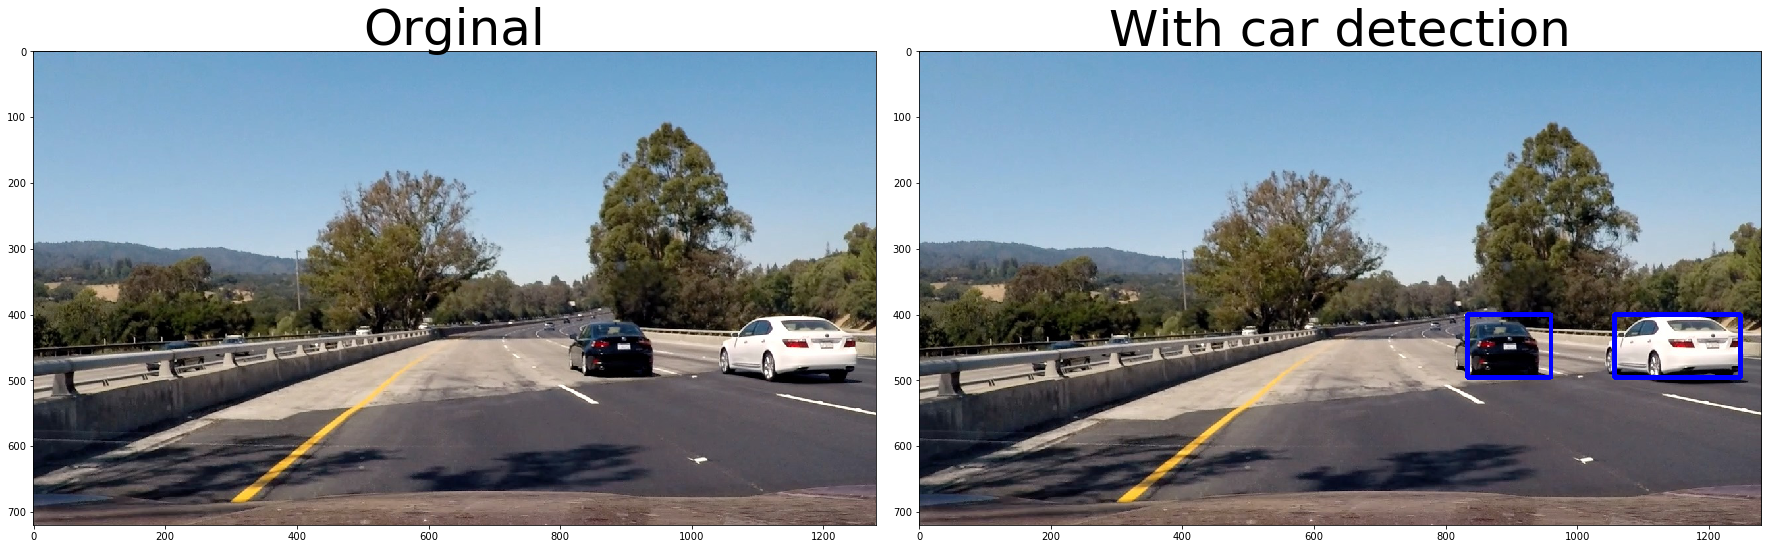

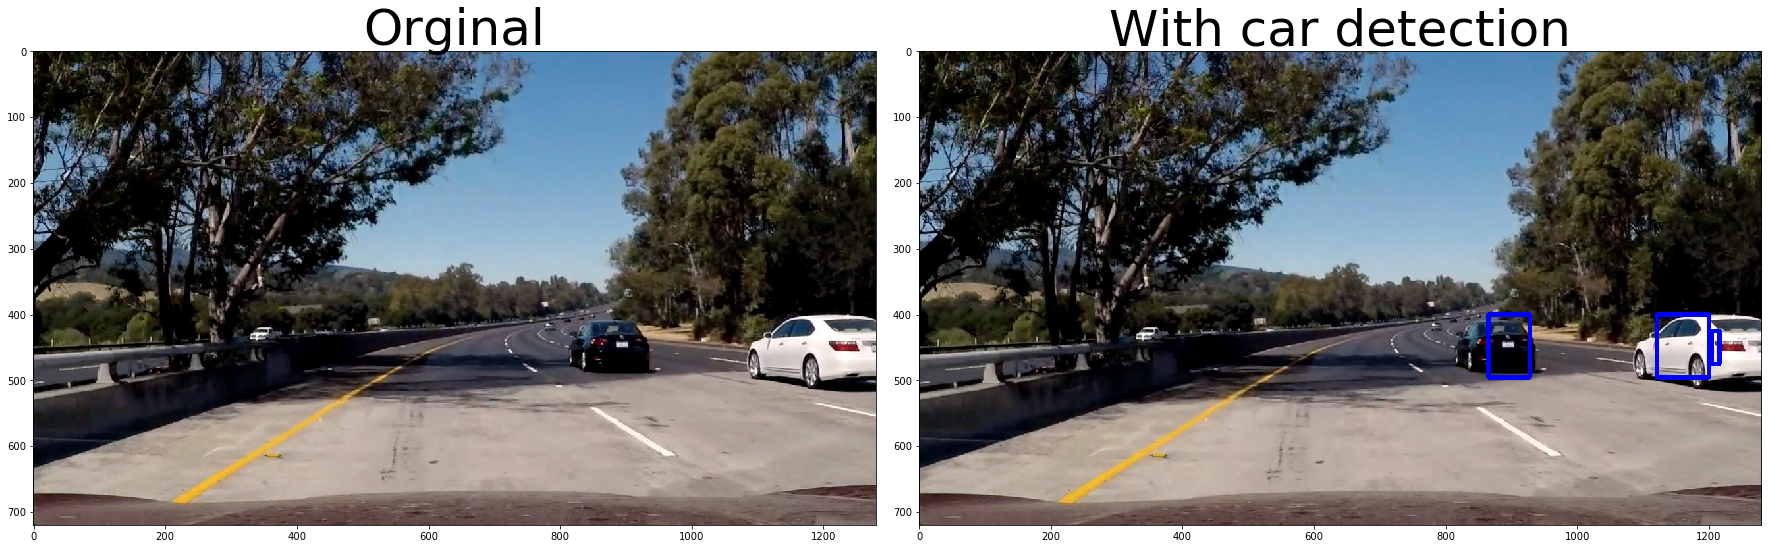

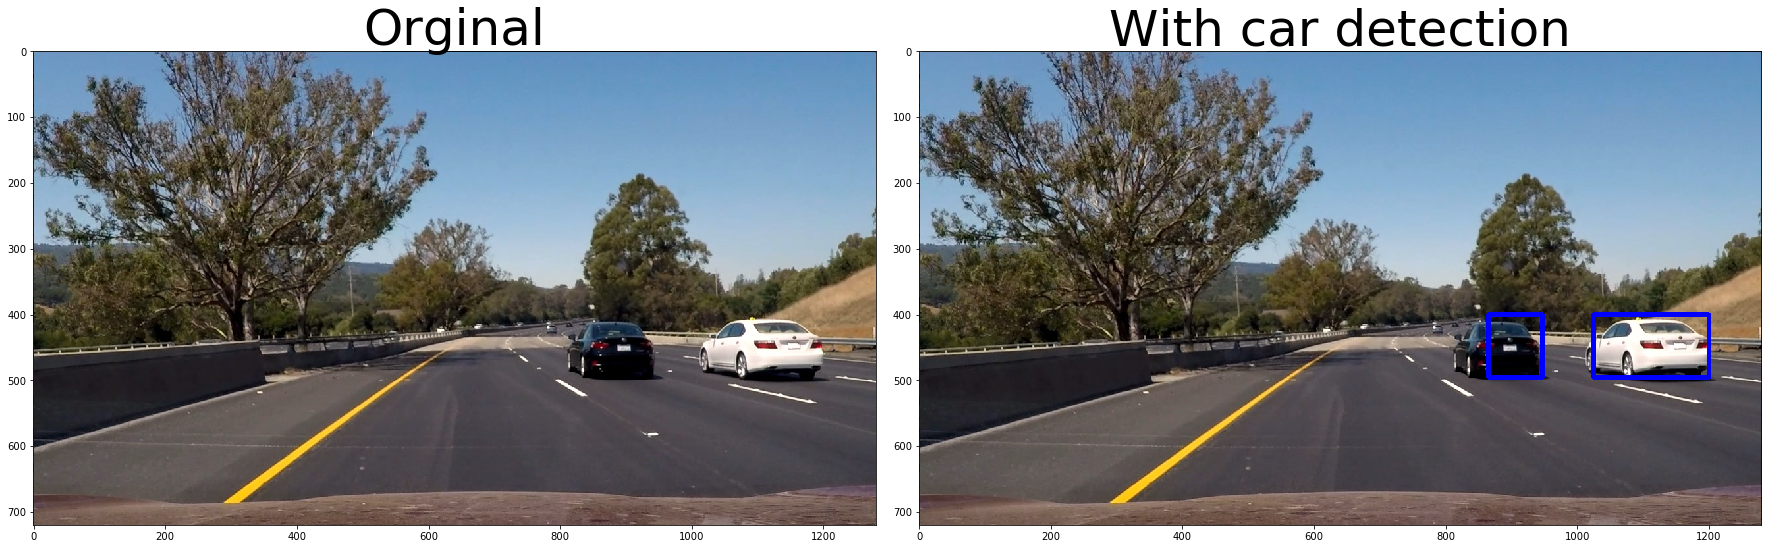

In [27]:
test_imgs = glob.glob('test_images/*.jpg')
for file in test_imgs:
    img = mpimg.imread(file)
    final_img = process_image(img)
    plotTwoImageInRow(img, final_img, 'Orginal', 'With car detection')

## 3. Video Implementation ##

**Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
**

- I have added the respective video files inside the repo - **test_video_result.mp4** for **test_video.mp4** and **project_video_result.mp4** for **project_video.mp4**. I have also saved this notebook as html and pdf files in the repo.

In [28]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [29]:
# Test Video pipeline
test_vid_res = 'test_video_result.mp4'
test_video = VideoFileClip('test_video.mp4')
result = test_video.fl_image(process_image)
result.write_videofile(test_vid_res, audio=False)

[MoviePy] >>>> Building video test_video_result.mp4
[MoviePy] Writing video test_video_result.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:23<00:00,  1.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_result.mp4 



In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_vid_res))

In [36]:
def process_image_with_caching(image_frame):
    
    global rectangles_hist
    global threshold
    
    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    
    ystart = 400
    yend = 656
    
    # getting the rectangle
    rectangles_found = []
    rectangles_found.append(find_cars_withing_area(image_frame, ystart=ystart, yend=yend, scale=4, isVideo=True))
    rectangles_found.append(find_cars_withing_area(image_frame, ystart=ystart, yend=yend, scale=3, isVideo=True))
    rectangles_found.append(find_cars_withing_area(image_frame, ystart=ystart, yend=yend, scale=2, isVideo=True))
    rectangles_found.append(find_cars_withing_area(image_frame, ystart=ystart, yend=yend, scale=1.5, isVideo=True))
    
    rectangles_found = [item for rec in rectangles_found for item in rec]
    
    if len(rectangles_found) > 0:
        rectangles_hist.append(rectangles_found)
        # delete extra if length is greater than threshold
        if len(rectangles_hist) > threshold:
            rectangles_hist = rectangles_hist[-threshold:]
    
    # analysing the heatmaps for final rectangles to draw for each car, if any
    if len(rectangles_hist) > 0:
        heatmap = np.zeros_like(image_frame[:,:,0])
        for rect in rectangles_hist:
            heatmap = add_heat(heatmap, rect)
        heatmap = apply_threshold(heatmap, 8)
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image_frame), labels)

        return draw_img
    else:
        return image_frame

**Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes**

I have create **rectangles_hist** to hold the rectangles found in the frame and **threshold** to put a limit on upto how many frames the data needs to be persisted. **rectangles_hist** will always contain the latest 10 elements and in case it increase in size then it will pop out the oldest ones.

In [37]:
# this will hold the rectangles found in the video for 5 frames if more, oldest will be removed from
# this list
rectangles_hist = []
threshold = 10

project_vid_res = 'project_video_result.mp4'
project_video = VideoFileClip('project_video.mp4')
result = project_video.fl_image(process_image_with_caching)
result.write_videofile(project_vid_res, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:12<00:00,  4.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 



In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_vid_res))

## Discussion

**Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?
**

This was a tricky project with many moving parts to tune. One of the major problem I faced was whether to go with HOG features only or include other features like spatial or color histogram. Another thing which took a lot of time was fine tuning scaling and video pipeline.

I think there still needs a lot to be done with this project. Like, right now the pipeline works, but to have greater predictebility in variable conditions it might gitter a bit. Also, to recognise smaller cars and cars on left lane I would need to better optimise the pipeline to consider finer details.

I think increating the data to around 15k would help the classifier learn better. Also, I think experimenting with a DeepLearning / CNN  route could also be worthwhile. It may take them time and power to learn, but, they might be better at predicting.